**TASK:** Design a convolutional autoencoder for a dataset of images $3 \times 224 \times 224$. The output of the encoder should have the total dimension (when flatened) equal to 512. Train it on the [NEU Dataset](https://github.com/smahesh2694/NEU_XAI) for 50 epochs.

1. When finished training, create 50 reconstructions $\hat{x}$ of randomly selected test NEU images.
2. Test a modified pretrained classifier (e.g. resnet18) on these 50 reconstructed images and compare the accuracy with the 50 original images.
3. Results do not have to be good, i.e. the autoencoder does not have to perfectly reconstruct.

# 1 - ConvNets
<hr>

Convolutional neural networks take in a 2-dimensional spatial structured data instance (an image), and process it until a 1-dimensional vector representation of some sort is produced. It then begs the question that if a mapping can be learnt from an image matrix to a vector representation, perhaps a mapping can be learnt from that vector representation back to an image.

### 1.1 - Convnets as Feature Extractors

Convolution layers in a convnet serve the purpose of extracting features from images. Those features are then passed unto linear layers which perform the actual classification.

<br>

<div style="align:center">
    <img src="media/vgg16.png" width=900>
</div>

Consider VGG-16 with it's architecture depicted above, from the input layer right till the point where the pooled $7 \times 7 \times 512$ feature maps are flattened to create a vector of size $25,088$ elements: that portion of the network serves as a feature extractor. Essentially, a $224 \times 224$ image with a total of $50,176$ pixels is processed to create a $25,088$ element feature vector, and this feature vector is then passed to the linear layers for classification.

Since these features are extracted by a convnet, it is logical to assume that another convnet could possibly make sense of these features, and put the original image that those features belong to back together, basically reversing the feature extraction process. This is essentially what an Autoencoder does.

# 2 - Structure of an Autoencoder

<hr>

Autoencoders are deep learning architectures capable of reconstructing data instances from their feature vectors. An autoencoder is made up of 3 main components; namely, an encoder, a bottleneck and a decoder.

<br>

<div style="align:center">
    <img src="media/autoencoder_structure.png" width=600>
</div>


### 2.1 - Encoder
The first section of an autoencoder, the encoder is the convnet that acts specifically as a feature extractor. Its primary function is to help extract the most salient features from images and return them as a vector.

### 2.2 - Bottleneck
Located right after the encoder, the bottleneck, also called a code layer, serves as an extra layer which helps to compress the extracted features into a smaller vector representation. This is done in a bid to make it more difficult for the decoder to make sense of the features and force it to learn more complex mappings.

### 2.3 - Decoder
The last section of an autoencoder, the decoder is that convnet which attempts to make sense of the features coming from the encoder, which have been subsequently compressed in the bottleneck, so as to reconstruct the original image as it was.

# 3 - Training an Autoencoder

Let's implement an autoencoder from scratch in PyTorch and train it on the NEU dataset.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from torch.utils.data import random_split, DataLoader

In [2]:
# configuring device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


### 3.1 - Preparing Data

In [3]:
def load_image(img_path):
    np_img = cv2.imread(img_path)
    return Image.fromarray(np_img)

In [4]:
# We need to write a transform to make dataset compatible with (size 224x224x3, and type tensor)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [5]:
# NEUdata has 6 folders each containing 300 bmp files
dset = DatasetFolder(root='NEUdata', loader=load_image, extensions=('.bmp',), transform=transform)

In [6]:
train_set, val_set = random_split(dset, [1200, 600])

trainloader = DataLoader(train_set, batch_size=16, shuffle=True)
valloader = DataLoader(val_set, batch_size=16, shuffle=True)

**Encoder:**
- Convolutional and pooling layers to downsample the image, reducing spatial dimensions while increasing depth (channel size), until reaching the flattened size of 512.

**Decoder:**
- Transposed convolutional layers (or upsample + convolutional layers) to upsample the image back to its original spatial dimensions.

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1) # 112x112
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1) # 56x56
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 28x28
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # 14x14
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # 7x7
        self.fc = nn.Linear(256*7*7, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(512, 256*7*7)
        self.convT1 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1) # 14x14
        self.convT2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1) # 28x28
        self.convT3 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1) # 56x56
        self.convT4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1) # 112x112
        self.convT5 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1) # 224x224

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, 7, 7)
        x = F.relu(self.convT1(x))
        x = F.relu(self.convT2(x))
        x = F.relu(self.convT3(x))
        x = F.relu(self.convT4(x))
        x = torch.sigmoid(self.convT5(x))
        return x

In [9]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
autoencoder = ConvAutoencoder()

### 3.2 - Training

In [11]:
autoencoder.to(device)

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=12544, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=12544, bias=True)
    (convT1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [13]:
N_EPOCHS = 50

train_loss_history = []
val_loss_history = []

for epoch in range(N_EPOCHS):
    train_loss = 0.0
    val_loss = 0.0
    
    # Training
    autoencoder.train()
    for data in trainloader:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0)
    
    # Validation
    autoencoder.eval()
    with torch.no_grad():
        for data in valloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            
            val_loss += loss.item()*inputs.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    val_loss = val_loss/len(valloader.dataset)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

Epoch: 1 	Training Loss: 0.709564 	Validation Loss: 0.491892
Epoch: 2 	Training Loss: 0.488734 	Validation Loss: 0.400281
Epoch: 3 	Training Loss: 0.445952 	Validation Loss: 0.390981
Epoch: 4 	Training Loss: 0.436359 	Validation Loss: 0.383075
Epoch: 5 	Training Loss: 0.429527 	Validation Loss: 0.379285
Epoch: 6 	Training Loss: 0.425684 	Validation Loss: 0.377518
Epoch: 7 	Training Loss: 0.422194 	Validation Loss: 0.373631
Epoch: 8 	Training Loss: 0.419080 	Validation Loss: 0.373197
Epoch: 9 	Training Loss: 0.417389 	Validation Loss: 0.371242
Epoch: 10 	Training Loss: 0.415445 	Validation Loss: 0.370270
Epoch: 11 	Training Loss: 0.413519 	Validation Loss: 0.371210
Epoch: 12 	Training Loss: 0.412480 	Validation Loss: 0.368284
Epoch: 13 	Training Loss: 0.411153 	Validation Loss: 0.368052
Epoch: 14 	Training Loss: 0.409707 	Validation Loss: 0.366187
Epoch: 15 	Training Loss: 0.408383 	Validation Loss: 0.365480
Epoch: 16 	Training Loss: 0.407537 	Validation Loss: 0.364657
Epoch: 17 	Traini

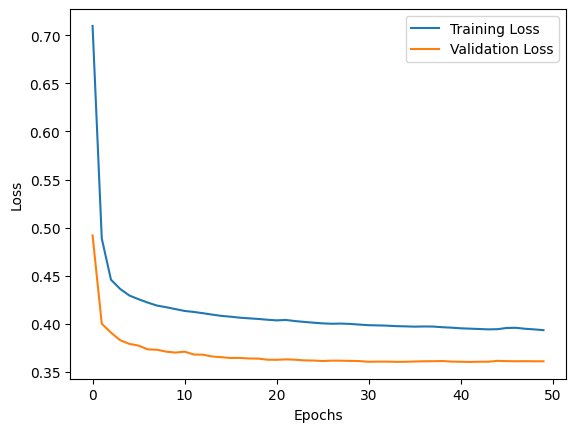

In [14]:
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# # Save the model
# torch.save(autoencoder.state_dict(), './models/autoencoder.pth')

In [12]:
# Load and re-use model
autoencoder.load_state_dict(torch.load('./models/autoencoder.pth'))
autoencoder.eval()

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=12544, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=12544, bias=True)
    (convT1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 

In [13]:
test_dataset = DatasetFolder(root='NEUdata_split/Test', loader=load_image, extensions=('.bmp',), transform=transform)

# Load 50 images at once, assuming there are at least 50 images
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

In [15]:
images, _ = next(iter(test_loader))
images = images.to(device)

# Generate reconstructions
with torch.no_grad():
    reconstructions = autoencoder(images)

# Convert images to numpy for plotting
images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
reconstructions_np = reconstructions.cpu().numpy().transpose(0, 2, 3, 1)

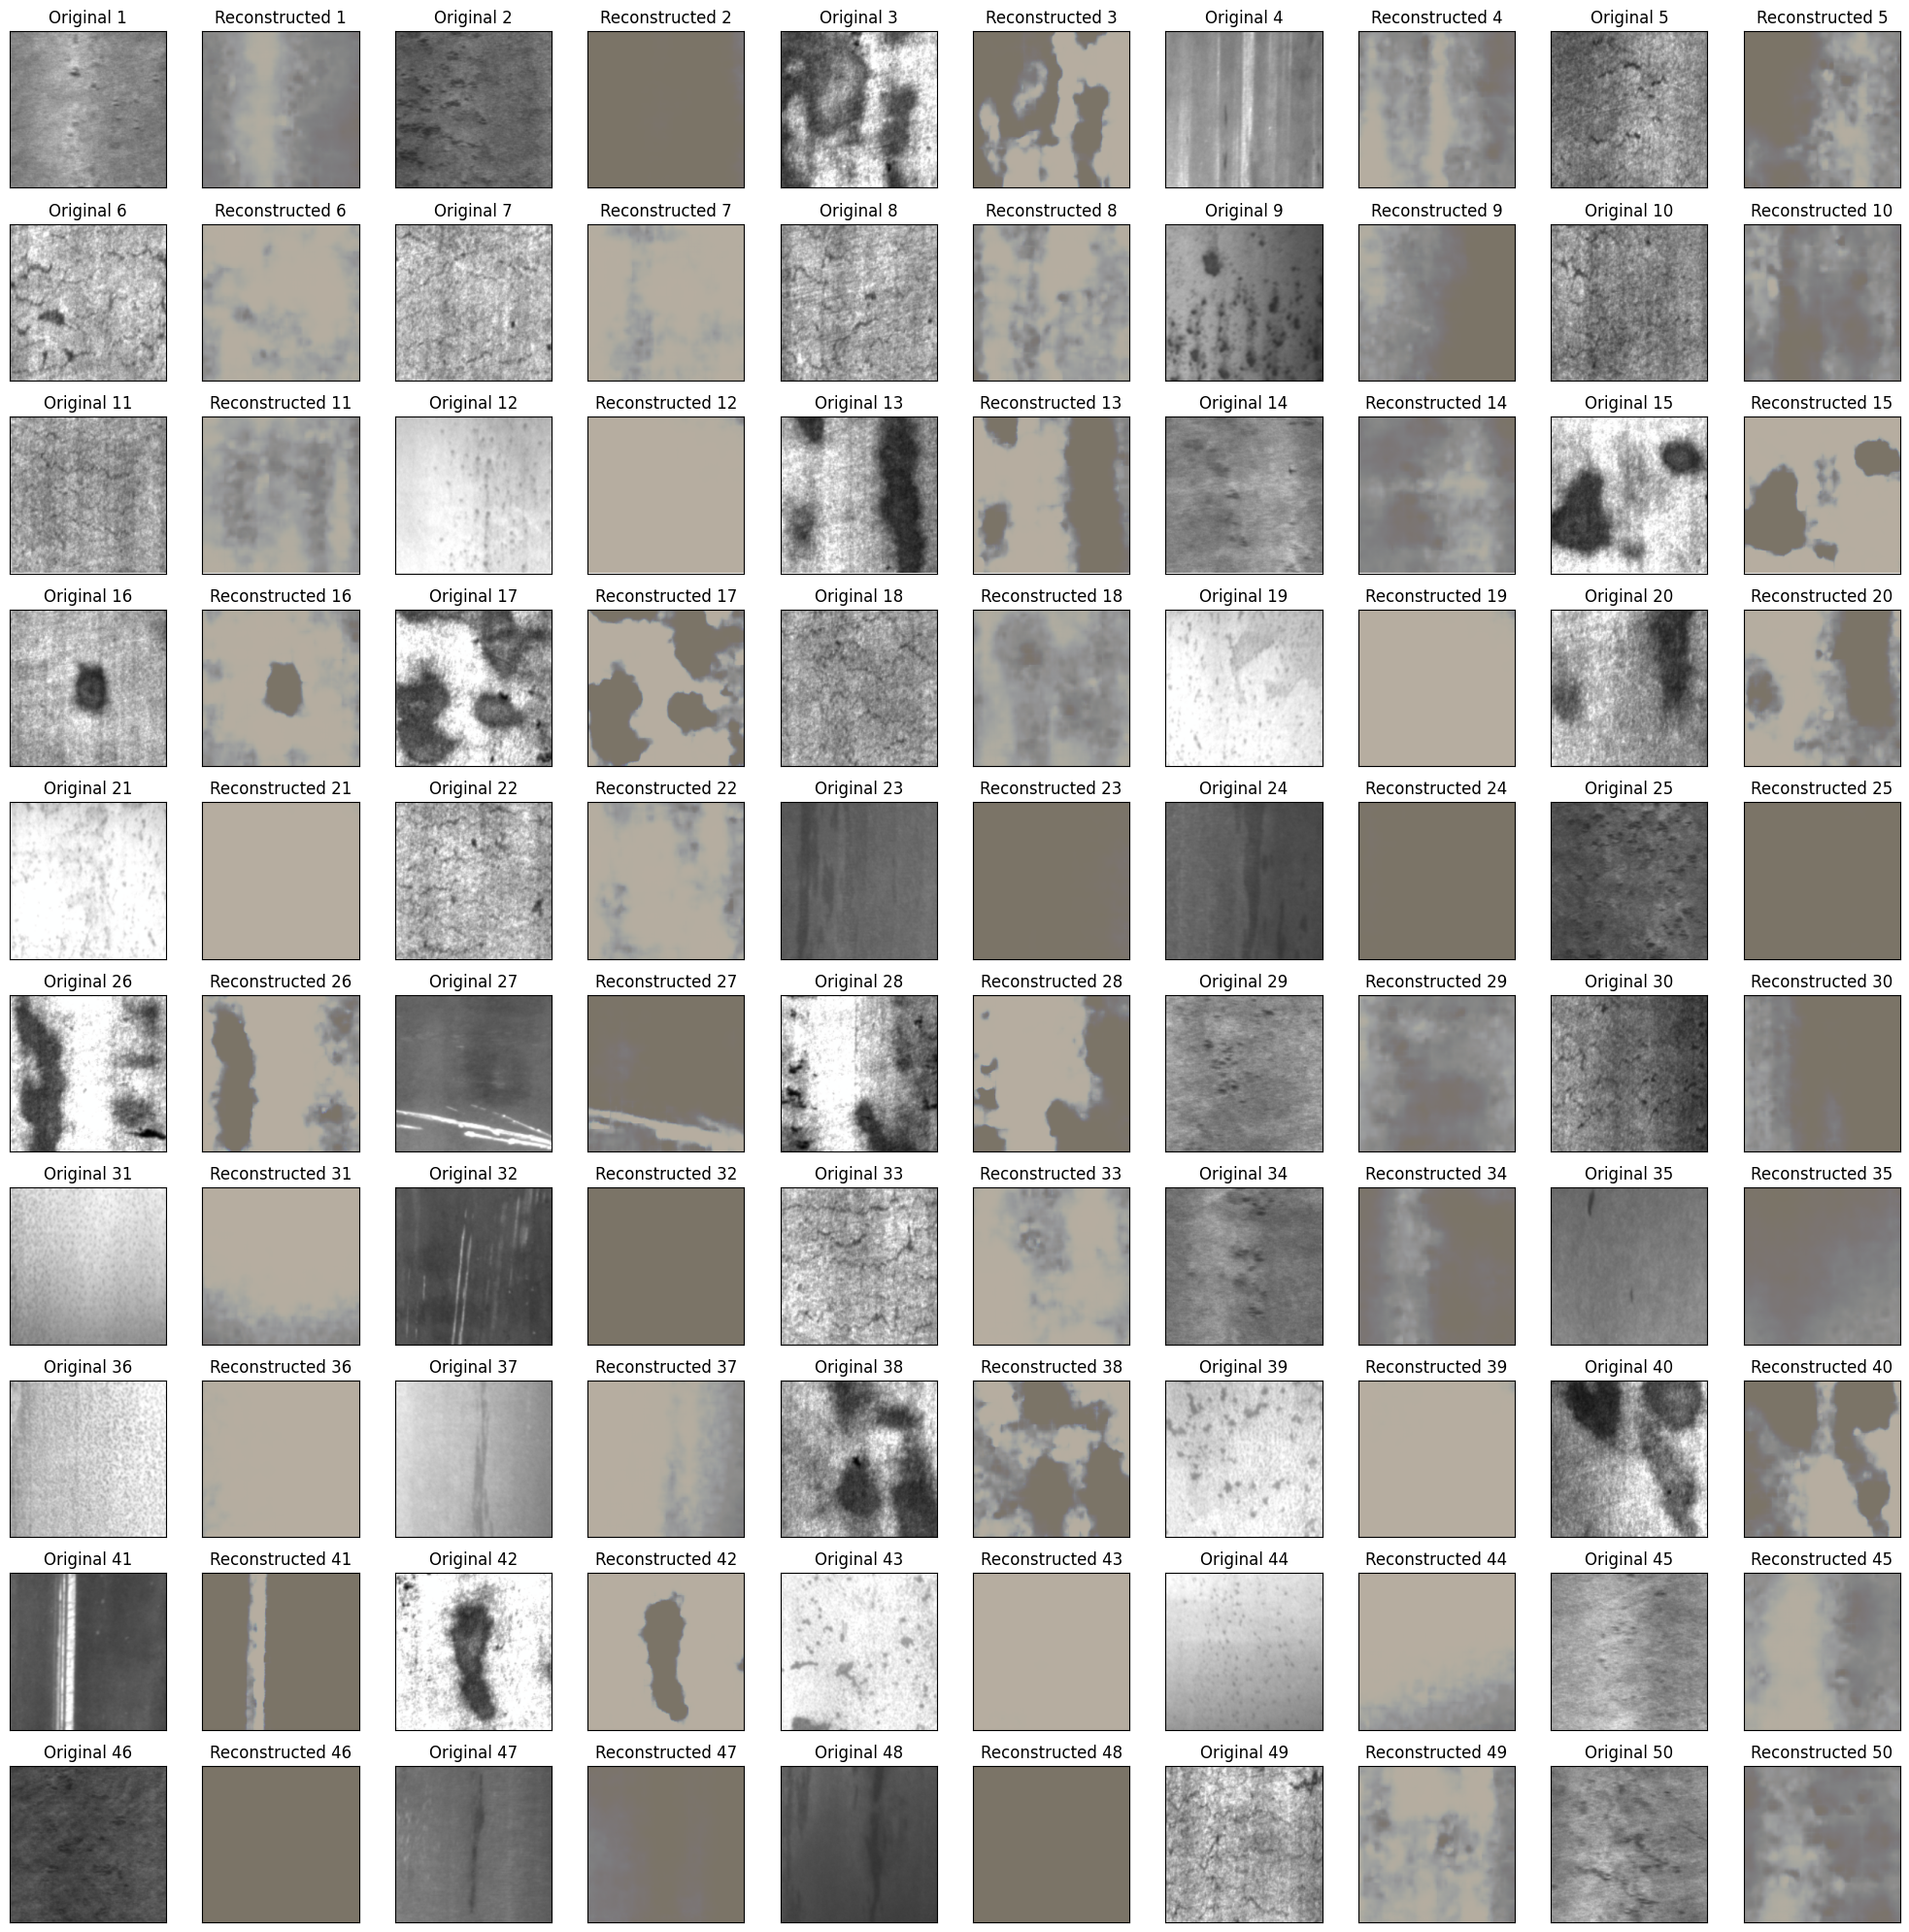

In [16]:
# Define mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Un-normalize the images for visualization
images_np = images_np * std + mean
reconstructions_np = reconstructions_np * std + mean

# Ensure the data is in the valid range
images_np = np.clip(images_np, 0, 1)
reconstructions_np = np.clip(reconstructions_np, 0, 1)

# Visualization code remains the same
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
for i in range(50):
    ax = axes[i // 5, (i % 5) * 2]  # Even indices for original images
    ax.imshow(images_np[i], cmap='gray')
    ax.set_title(f'Original {i+1}')
    
    ax = axes[i // 5, (i % 5) * 2 + 1]  # Odd indices for reconstructed images
    ax.imshow(reconstructions_np[i], cmap='gray')
    ax.set_title(f'Reconstructed {i+1}')

plt.tight_layout()
plt.show()

**OBSERVATIONS:** The quality of the reconstructed images is not good suggesting that the autoencoder is struggling to recognize the patterns it was trained on. This could be a sign that the autoencoder needs further training or architectural adjustments to improve the quality of the reconstructions.

<font color="purple">Test the modified pretrained classifier `modified_resnet18` on these 50 reconstructed images and compare the accuracy with the 50 original images.</font>

In [18]:
from torchvision import models

In [32]:
# Initialize the original ResNet18 model without pretrained weights
orig_model = models.resnet18(weights=False)

# Get all the layers except the last one
layers = list(orig_model.children())[:-1]
layers.append(nn.Flatten())

# Create a model with the modified layers
modified_model = nn.Sequential(*layers)

# Stop gradients for all layers in the modified model so far
for param in modified_model.parameters():
    param.requires_grad = False

# Add custom final layer to the modified model
# Note: Since nn.Sequential does not accept adding layers after creation, 
# we create a new sequential model including all previous layers and the new layer
final_layers = list(modified_model.children())
final_layers.append(nn.Linear(512, 6))
final_model = nn.Sequential(*final_layers)

# Load the state dictionary (ensure 'device' is defined correctly)
final_model.load_state_dict(torch.load('./models/tl_resnet.pth', map_location=device))

# Set the model to evaluation mode
final_model.to(device)
final_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [33]:
def test_accuracy(model, data_loader, device, use_reconstructed=False):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            if use_reconstructed:
                images = autoencoder(images)  # Reconstruct images if needed
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    return accuracy

In [34]:
# Compute accuracy on original images
original_accuracy = test_accuracy(final_model, test_loader, device, use_reconstructed=False)

In [35]:
# Compute accuracy on reconstructed images
reconstructed_accuracy = test_accuracy(final_model, test_loader, device, use_reconstructed=True)

In [36]:
print(f'Accuracy on original images: {original_accuracy:.2f}%')
print(f'Accuracy on reconstructed images: {reconstructed_accuracy:.2f}%')

Accuracy on original images: 98.33%
Accuracy on reconstructed images: 16.67%


### References

- [Paperspace](https://blog.paperspace.com/convolutional-autoencoder/)